## Softmax Regression

An extention of logistic regression for non-binary classifcation is called softmax/multinomial regression. This can also be seen as a one layer neural network in and of itself.

**MNIST** can be classifed from this methodology. 

In softmax regression we obtain a vector of probabilities for each $k \in \mathcal{C}$. This probability is obtained by applying the softmax function to the linear regression models for each class. That is

$$
\sigma_{\text{softmax}}: \mathbb{R}^{n\times1} \rightarrow [0,1]^{K\times 1}.
$$

The basic set up of using softmax regression is as follows:
1. Have a list of all features/covariates $\mathbf{x}$.
2. Apply the linear regression for each class, i.e., $\mathbf{w_i}^{\text{T}}\mathbf{x}~~i\in\{1,\ldots,K\}$.
3. Apply the softmax function to the output vector of the different linear regression scoring models.
4. Return the class which has the largest probability of being true.

Parameter optimization is done via MLE. The process is slightly more involved than for logistic regression. Suppose we have a training set $\mathcal{D} = \{(\mathbf{x}_i, \mathbf{t}_i)\}_{i=1}^n$. 

Each r.v. that is observed has some probability of being in a class $k \in \mathcal{C}$. Similarly to logistic regression we can write the probability of being in class $k$ given the obseervation $(\mathbf{x}, \mathbf{t}) \in \mathcal{D}$ and the weighting matrix $\mathbf{W}$ as 

$$
\mathbb{P}(Y = l| \mathbf{x}, \mathbf{W}) = p_1^{\mathbb{1}_{\{t_1 = l\}}} \cdot \ldots \cdot p_n^{\mathbb{1}_{\{t_n = l\}}}
.$$

With an entire dataset $\mathcal{D}$ we can derive a loss function using a likelihood based approach:

\begin{equation*}
    \begin{split}
        L(\mathbf{W}) \triangleq p(\mathcal{D}|\mathbf{W}) & = \mathbb{P}(Y_1 = t_1, \ldots, Y_n = t_n|\mathbf{W}) \\
        & = \mathbb{P}(Y_1 = t_1 | \mathbf{W})\ldots \mathbb{P}(Y_n = t_n | \mathbf{W})\\
        & = \prod_{i=1}^n \prod_{l=1}^K \Big[\frac{\exp{\mathbf{w}_l^{\text{T}}\mathbf{x_i}}}{\sum_{j=1}^K \exp{\mathbf{w}_j^{\text{T}}\mathbf{x_i}}} \Big]^{\mathbb{1}_{\{t_l^{(i)} = l\}}}.
    \end{split}
\end{equation*}

To simplify the mathematics slightly we introduce two new notations following Bishop. 

For a target vector $\mathbf{t}_j$ we introduce a new matrix $\mathbf{T} = [t_{ij}] \in \mathbb{R}^{n\times K}$ which keeps track of the values in a target vector, raning from $j=1,...,K$ for each sample $i=1,...,n$.

Secondly, we define 
$$
y_l(\mathbf{x}_i|\mathbf{W}) \triangleq \frac{\exp{\mathbf{w}_l^{\text{T}}\mathbf{x_i}}}{\sum_{j=1}^K \exp{\mathbf{w}_j^{\text{T}}\mathbf{x_i}}}.
$$
The likelihood function thus simplifies to 
\begin{equation*}
    \begin{split}
        L(\mathbf{W}) \triangleq p(\mathcal{D}|\mathbf{W}) & = \mathbb{P}(Y_1 = t_1, \ldots, Y_n = t_n|\mathbf{W}) \\
        & = \prod_{i=1}^n \prod_{l=1}^K \Big[y_l(\mathbf{x}_i|\mathbf{W}) \Big]^{t_{il}}.
    \end{split}
\end{equation*}
Next, we obtain the cost function by the negative log-likelihood as


\begin{equation*}
    \begin{split}
        \mathcal{J}(\mathbf{W}) \triangleq - \ln p(\mathcal{D}|\mathbf{W}) & = -\sum_{i=1}^n \sum_{l=1}^K t_{il} \ln (y_l(\mathbf{x}_i|\mathbf{W})),
    \end{split}
\end{equation*}

of which the gradients are calculated in the following manner

$$
\nabla_{\mathbf{w}_j}\mathcal{J}(\mathbf{W}) = \sum_{i=1}^N(y_j(\mathbf{x}_i) - t_{ij})\mathbf{x}_i \in \mathbb{R}^{M\times 1},
$$
where $M$ is the number of features. However, we can simplify this to a greater extent, to obtain the following expression instead:

$$
\nabla_{\mathbf{W}}\mathcal{J}(\mathbf{W}) = (\mathbf{Y}-\mathbf{T})^{\text{T}}\mathbf{X},
$$
where $\mathbf{Y}$ is the predicted values, $\mathbf{T}$ are the target values which are one-hot-encoded, and $\mathbf{X}$ are the input feature vectors stacked into a matrix.

To train the model we do this without any regularization of $\mathbf{W}$, and we use standard gradient decent, meaning 

$$
\mathbf{W}_{n+1} = \mathbf{W}_n + \eta \nabla_{\mathbf{W}}\mathcal{J}(\mathbf{W}).
$$

For some learning rate $\eta$, which will be set as a constant. 

#### 1. Importing Data

In [681]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

# Plotting configuration.
%config InlineBackend.figure_format = 'retina'
plt.style.use(['science', 'notebook', 'grid'])

In [682]:
# Importing MNIST dataset. 
from mnist_utils.data_reader import (TESTING_DATA,
                                     TESTING_LABELS,
                                     TRAINING_DATA,
                                     TRAINING_LABELS)

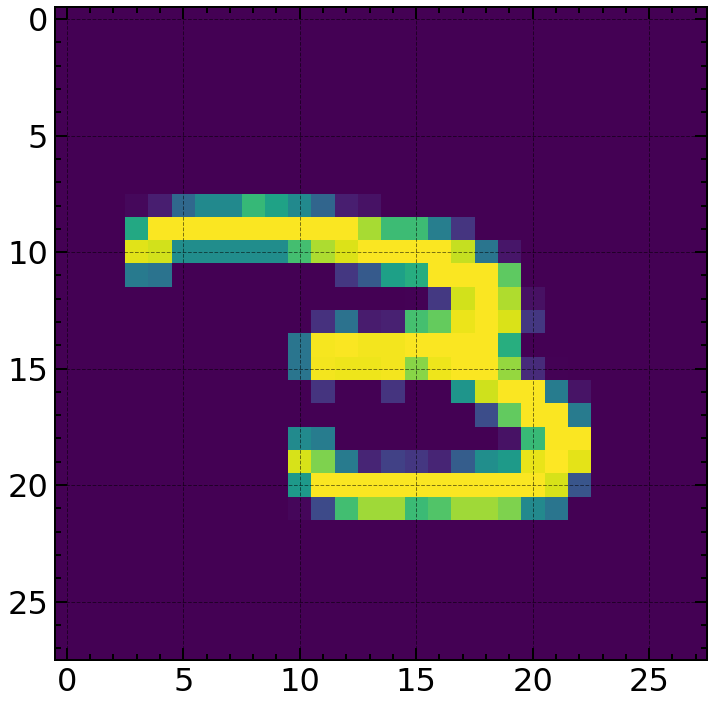

In [683]:
plt.imshow(TRAINING_DATA[250])
plt.show()

#### 2. Configuring Data and Encoding

In [684]:
def one_hot_encoding(array: np.array) -> np.array:
    
    data_length = len(array)
    feature_length = max(array) + 1
    dim  = (data_length, feature_length)
    one_hot_matrix = np.zeros(dim)

    for i in range(data_length):
        digit = array[i]
        one_hot_matrix[i][digit] = 1

    return one_hot_matrix

In [685]:
def vec(matrix: np.array) -> np.array:
    vec_matrix = np.zeros(0)
    
    return np.append(vec_matrix, matrix)

In [686]:
def softmax(x: np.array, W: np.array) -> np.array:
    score_vector = np.exp(W @ x.T - np.max(W @ x.T))
    normalizing_constant = np.sum(score_vector)

    return score_vector / normalizing_constant

def _Y_matrix(X: np.array, W: np.array) -> np.array:
    Y = []
    for x_data in X:
        Y.append(softmax(x_data, W))
    Y = np.stack(Y)
    
    return Y

In [687]:
T = one_hot_encoding(TRAINING_LABELS)

x_values = []
for digit in TRAINING_DATA:
    x_values.append(vec(digit))
ones = np.ones(60000)
X = np.stack(x_values)/255
X = np.insert(x_values, 0, ones, axis=1)

# Initial weight matrix W.
dim = (10, np.shape(X)[1])
W = np.random.uniform(-0.000000001, 0.000000001, dim)

#### 3. Cost Function and Jacobian Matrix

In [688]:
EPSILON = 1e-32

def cost(X: np.array, T: np.array, W: np.array) -> float:
    cost = 0
    dim = np.shape(T)
    Y = _Y_matrix(X, W)

    number_of_observations = dim[0]
    number_of_categories = dim[1]

    for i in range(number_of_observations):
        for j in range(number_of_categories):
            cost = cost - T[i][j] * np.log(Y[i][j]+ EPSILON)

    return cost

In [689]:
def gradient(X: np.array, T: np.array, W: np.array) -> np.array:
    Y = _Y_matrix(X, W)
    return (Y-T).T @ X

#### 4. Training

In [690]:
NUMBER_OF_ITERATIONS = 100
LEARNING_RATE = -0.02

for i in range(NUMBER_OF_ITERATIONS):
    # LOSS
    current_cost = cost(X, T, W)
    # Update weight
    W = W + LEARNING_RATE * gradient(X, T, W)
    print(f"Epoch: {i+1}/{NUMBER_OF_ITERATIONS}".ljust(1))
    print("-" * 40)
    print("Loss: " + str(int(current_cost)).rjust(34))
    print("Max Weight: " + str(np.max(W)).rjust(28))
    print("Min Weight: " + str(np.min(W)).rjust(28) + "\n")

Epoch: 1/100
----------------------------------------
Loss:                             138155
Max Weight:            19501.89157028934
Min Weight:          -16256.238452480946

Epoch: 2/100
----------------------------------------
Loss:                            1451033
Max Weight:           26865.348933753117
Min Weight:          -28835.212005970207

Epoch: 3/100
----------------------------------------
Loss:                            3020844
Max Weight:            40046.42121195428
Min Weight:           -99299.07906035174

Epoch: 4/100
----------------------------------------
Loss:                            2387762
Max Weight:            49966.41442377707
Min Weight:           -84033.51906035174

Epoch: 5/100
----------------------------------------
Loss:                            2541906
Max Weight:            61997.13442377707
Min Weight:           -72312.51724004382

Epoch: 6/100
----------------------------------------
Loss:                            2612273
Max Weight:    

#### 5. Accuracy

In [691]:
total_training = 10000
total_correct = 0
confusion_matrix = np.zeros((10, 10))

for i in range(total_training):
    data = np.insert(TESTING_DATA[i], 0, 1)
    prediction = int(np.argmax(softmax(data, W)))
    answer = int(TESTING_LABELS[i])

    if (prediction == answer):
        total_correct = total_correct + 1

    confusion_matrix[prediction][answer] += 1

In [692]:
# Total accuracy.
total_correct / total_training

0.9075

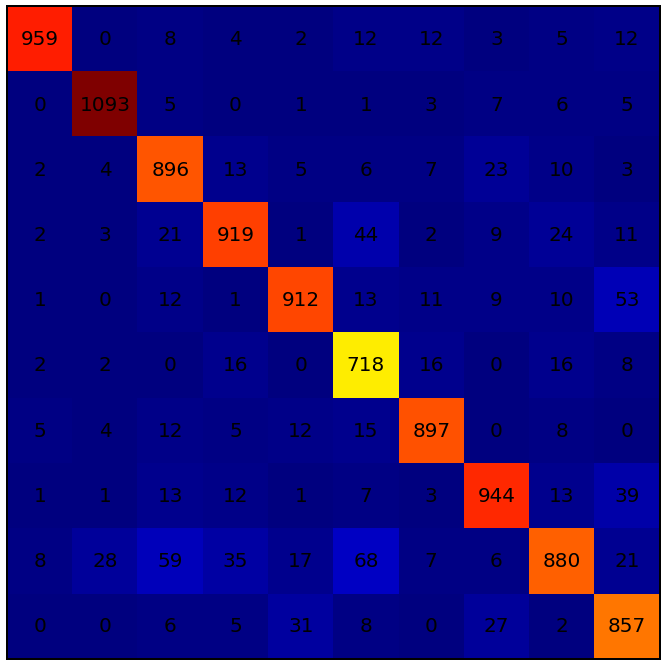

In [693]:
# Confusion matrix.
fig, ax = plt.subplots()
ax.matshow(confusion_matrix, cmap=plt.cm.jet)

for i in range(10):
    for j in range(10):
        c = confusion_matrix[j,i]
        ax.text(i, j, int(c), va='center', ha='center', color='black')
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)